## Installing the package

In [1]:
import causalimpact

## Creating an example dataset

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions


In [3]:
DATA_SEED = (0, 1)
NOISE_SEED = (1, 2)

rv = tfp.sts.AutoregressiveMovingAverageStateSpaceModel(
    num_timesteps=100,
    ar_coefficients=[0.999],
    ma_coefficients=[],
    level_scale=1.0,
    initial_state_prior=tfd.MultivariateNormalDiag([0.0], [1.0]),
)

x1 = (100.0 + rv.sample(seed=DATA_SEED))[..., 0]
y = 1.2 * x1 + tfd.Normal(0.0, 1.0).sample(100, seed=NOISE_SEED)

y = tf.where(tf.range(0, y.shape[0]) <= 71, y, y + 10.0)

data = pd.DataFrame(
    data={"y": y, "x1": x1}, index=pd.date_range("2021-06-14", "2021-9-21")
)

data.head()

,y,x1
2021-06-14,119.609077,99.220802
2021-06-15,120.141434,99.945038
2021-06-16,121.856659,101.485909
2021-06-17,122.528160,102.068100
2021-06-18,121.930687,102.693558


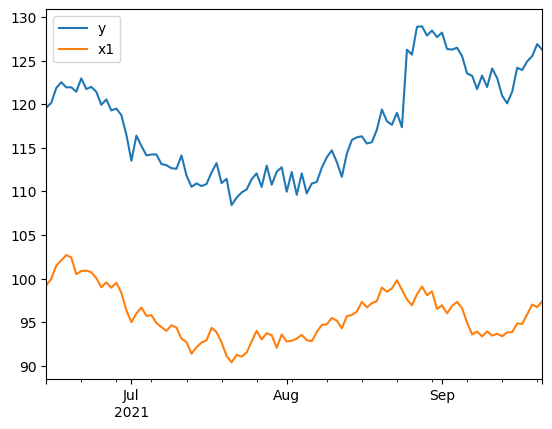

In [5]:
data.plot.line();

## Running an analysis

In [6]:
pre_period = (data.index[0], data.index[70])
post_period = (data.index[71], data.index[-1])

In [7]:
%%time 
impact = causalimpact.fit_causalimpact(
    data=data, pre_period=pre_period, post_period=post_period
)

I0000 00:00:1739039896.691302 30142869 service.cc:148] XLA service 0x1569cc890 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739039896.691344 30142869 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1739039896.960945 30142869 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


CPU times: user 2.47 s, sys: 230 ms, total: 2.7 s
Wall time: 1.97 s


## Plotting the results

In [8]:
causalimpact.plot(impact)

alt.FacetChart(...)

## Printing a summary table


In [9]:
print(causalimpact.summary(impact, output_format="summary"))


Posterior Inference {CausalImpact}
                          Average            Cumulative
Actual                    124.8              3619.0
Prediction (s.d.)         115.0 (0.39)       3334.7 (11.19)
95% CI                    [114.2, 115.7]     [3311.3, 3356.2]

Absolute effect (s.d.)    9.8 (0.39)         284.3 (11.19)
95% CI                    [9.1, 10.6]        [262.8, 307.8]

Relative effect (s.d.)    8.5% (0.4%)        8.5% (0.0%)
95% CI                    [7.8%, 9.3%]       [7.8%, 9.3%]

Posterior tail-area probability p: 0.001
Posterior prob. of a causal effect: 99.89%

For more details run the command: summary(impact, output_format="report")


/Users/scattes/Library/Caches/pypoetry/virtualenvs/ts-causalimpact-uGok5HKj-py3.12/lib/python3.12/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


There is also a verbose implementation:

In [10]:
print(causalimpact.summary(impact, output_format="report"));


Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 124.8. By contrast, in the absence of an
intervention, we would have expected an average response of 115.0.
The 95% interval of this counterfactual prediction is [114.2, 115.7].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 9.8 with a 95% interval of
[9.1, 10.6]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 3619.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 3334.7. The 95% interval of this prediction is [3311.3, 3356.2].


The above results are given in terms of absolute numbers. In relative
terms, the response variable s

/Users/scattes/Library/Caches/pypoetry/virtualenvs/ts-causalimpact-uGok5HKj-py3.12/lib/python3.12/site-packages/causalimpact/summary.py:149: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = ci_model.summary["p_value"][0]


## Working with dates and times

The API allows the pre_period and post_period to be specified in a few different formats:

In [12]:
# Using elements from the index
pre_period = (data.index[0], data.index[70])
post_period = (data.index[71], data.index[-1])
pre_period


(Timestamp('2021-06-14 00:00:00'), Timestamp('2021-08-23 00:00:00'))

In [13]:
# Using integers into the index. If your index is not a datetime index, this
# may be the only way!
pre_period = (0, 70)
post_period = (71, 99)

In [14]:
# Using strings. These have to match index elements after
# calling `pd.to_datetime`
pre_period = ("2021-06-14", "2021-08-23")
post_period = ("2021-08-24", "2021-09-21")
